## Testando o modelo ARIMA

In [1]:
import utils
pd, np, plt, go, seasonal_decompose, MinMaxScaler, mean_squared_error, train_test_split, warnings, stats, adfuller = utils.import_libraries()
df = utils.preparing_df()
%matplotlib inline

In [2]:
df.head()

,y
ds,
2004-01-02,22.445
2004-01-05,23.532
2004-01-06,23.576
2004-01-07,23.320
2004-01-08,23.717


### Analisando a correlação dos dados:

#### ACF (autocorrelação) temos a correlação direta e indireta.

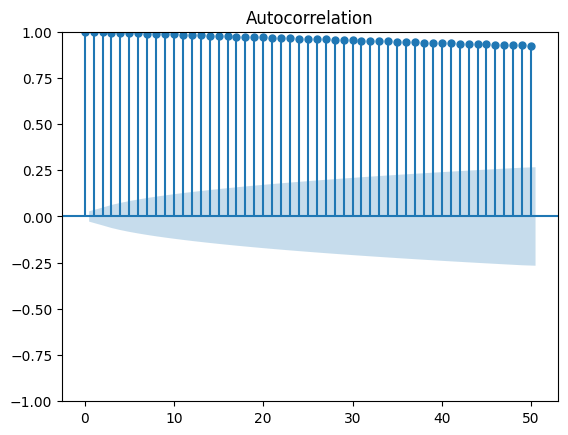

In [3]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df, lags=50)
plt.show()

#### PACF (autocorrelação parcial): apenas a correlação direta.

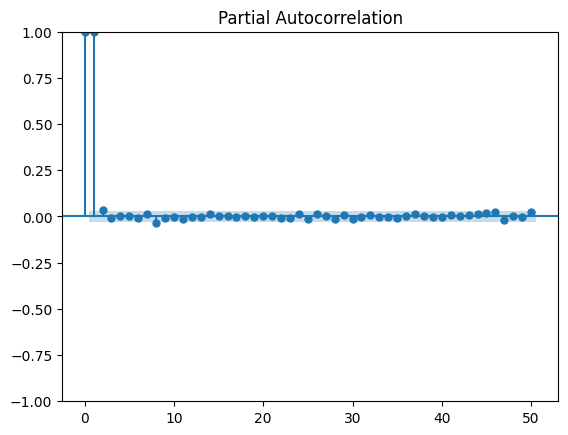

In [4]:
sm.graphics.tsa.plot_pacf(df, lags=50)
plt.show()

## Verificar estacionariedade da série temporal

### Teste de Dickey-Fuller

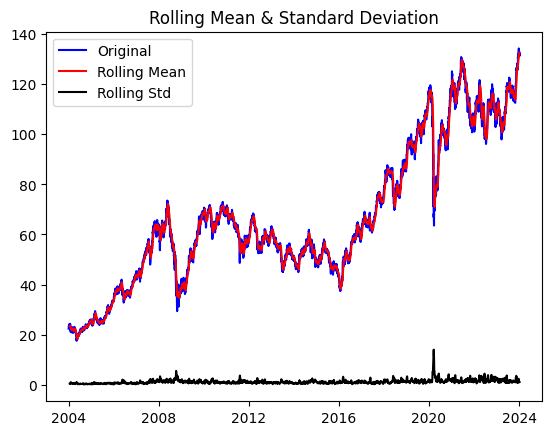

Results of Dickey Fuller Test:
Test Statistic                   -0.966723
p-value                           0.765207
#Lags Used                       11.000000
Number of Observations Used    4945.000000
Critical Value (1%)              -3.431673
Critical Value (5%)              -2.862125
Critical Value (10%)             -2.567081
dtype: float64
Conclusão: A série NÂO é Estacionária.


In [5]:
utils.test_stationarity(df)

## Transformando a série e estacionária

### 1º teste: Dados transformados pelo log - média móvel.

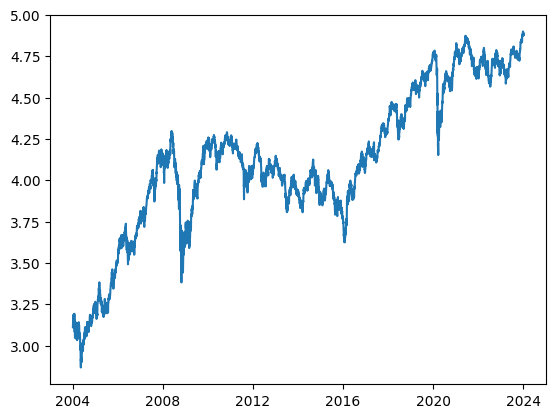

In [6]:
df_log = np.log(df)
plt.plot(df_log)

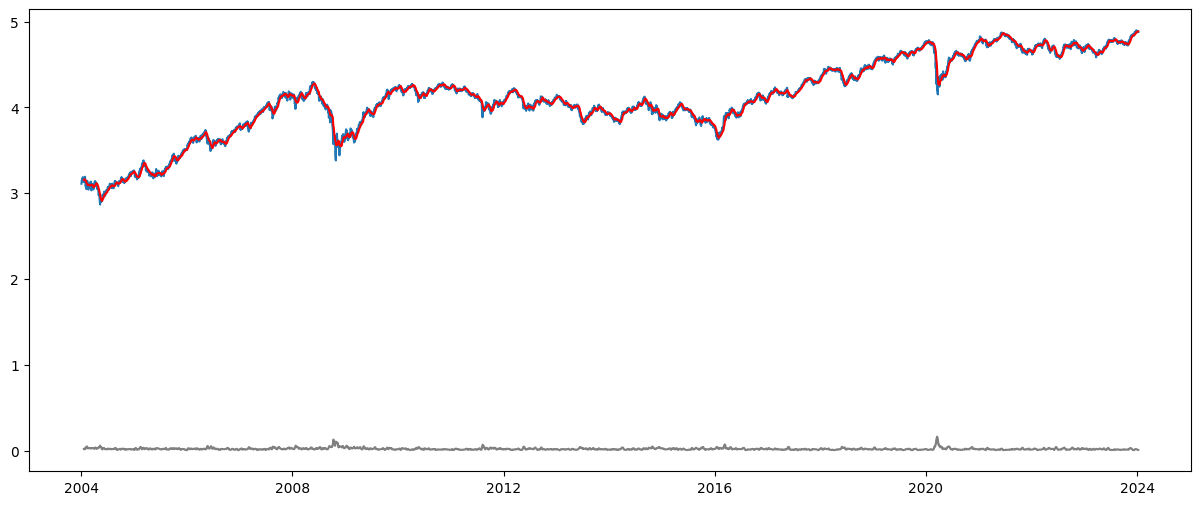

In [11]:
MA = df_log.rolling(window=12).mean()
STD = df_log.rolling(window=12).std()
plt.figure(figsize=(15,6))
plt.plot(df_log)
plt.plot(MA, color='red')
plt.plot(STD, color='gray')

In [8]:
dsLogMinusMa = df_log - MA
dsLogMinusMa.head(12)

,y
ds,
2004-01-02,NaN
2004-01-05,NaN
2004-01-06,NaN
2004-01-07,NaN
2004-01-08,NaN
2004-01-09,NaN
2004-01-12,NaN
2004-01-13,NaN
2004-01-14,NaN


In [9]:
dsLogMinusMa.dropna(inplace=True)
dsLogMinusMa.head(12)

,y
ds,
2004-01-19,-0.003240
2004-01-20,0.004793
2004-01-21,-0.010438
2004-01-22,-0.022658
2004-01-23,-0.001575
2004-01-26,0.032996
2004-01-27,0.026821
2004-01-28,0.012597
2004-01-29,-0.045243


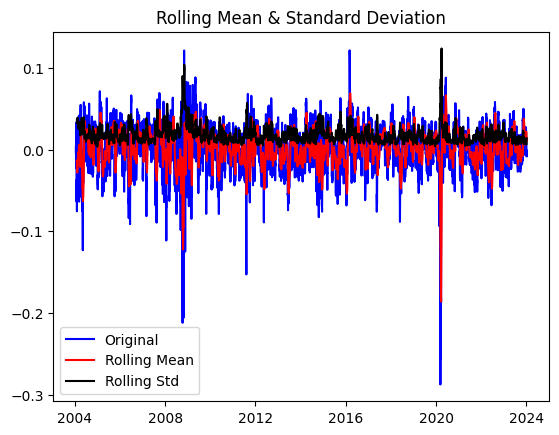

Results of Dickey Fuller Test:
Test Statistic                -1.318513e+01
p-value                        1.174368e-24
#Lags Used                     2.000000e+01
Number of Observations Used    4.925000e+03
Critical Value (1%)           -3.431678e+00
Critical Value (5%)           -2.862127e+00
Critical Value (10%)          -2.567082e+00
dtype: float64
Conclusão: A série é Estacionária.


In [10]:
utils.test_stationarity(dsLogMinusMa)

### 2º teste : Decaimento exponencial.

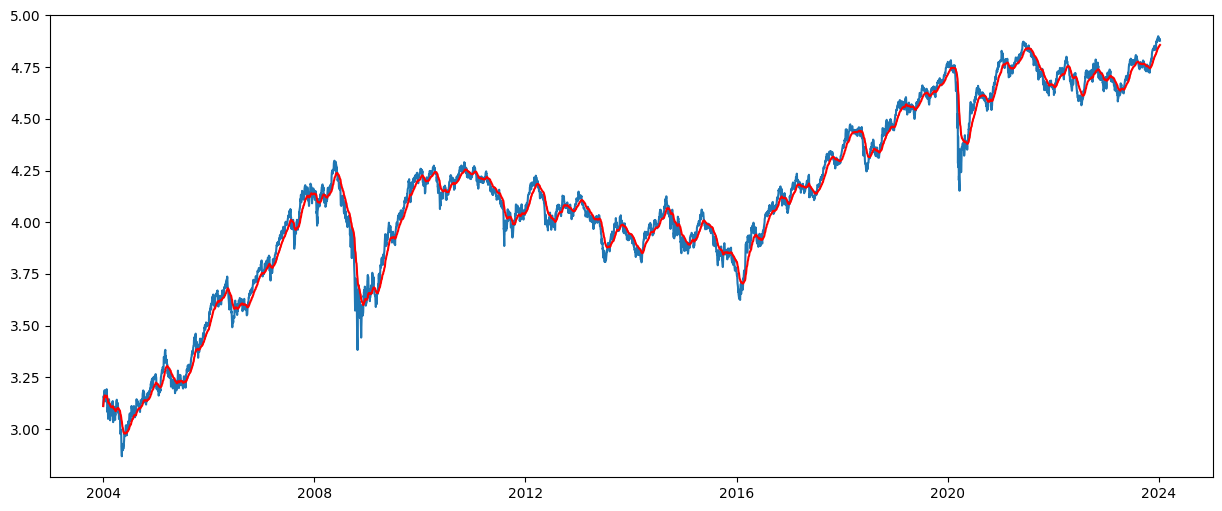

In [13]:
exponentialDecayWeightedAverage = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.figure(figsize=(15,6))
plt.plot(df_log)
plt.plot(exponentialDecayWeightedAverage, color='red')

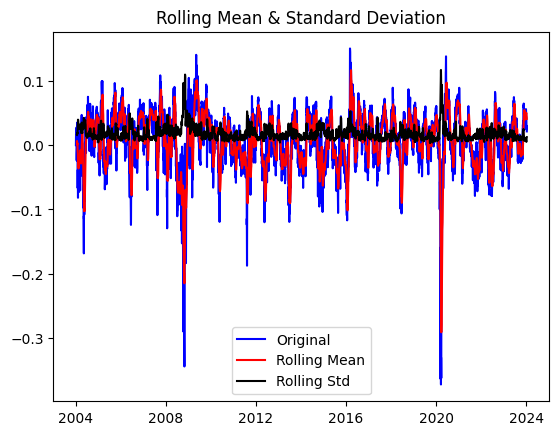

Results of Dickey Fuller Test:
Test Statistic                -1.022975e+01
p-value                        5.065306e-18
#Lags Used                     6.000000e+00
Number of Observations Used    4.950000e+03
Critical Value (1%)           -3.431672e+00
Critical Value (5%)           -2.862124e+00
Critical Value (10%)          -2.567081e+00
dtype: float64
Conclusão: A série é Estacionária.


In [14]:
datasetLogScaleMinusExponentialMovingAverage = df_log - exponentialDecayWeightedAverage
utils.test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

### 3º teste : Diferenciação

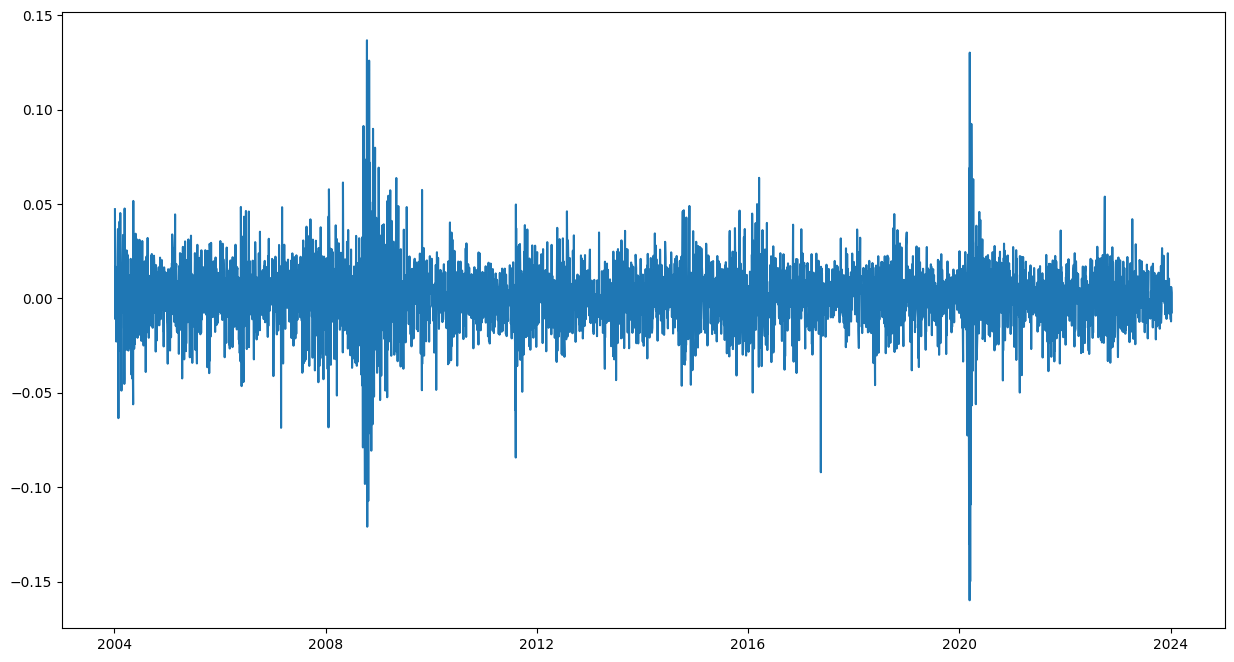

In [15]:
datasetLogDiffShifting = df_log - df_log.shift()
plt.figure(figsize=(15,8))
plt.plot(datasetLogDiffShifting)

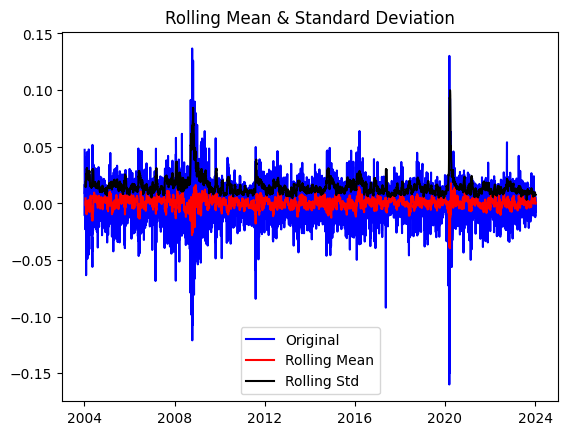

Results of Dickey Fuller Test:
Test Statistic                  -30.905184
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    4950.000000
Critical Value (1%)              -3.431672
Critical Value (5%)              -2.862124
Critical Value (10%)             -2.567081
dtype: float64
Conclusão: A série é Estacionária.


In [16]:
datasetLogDiffShifting.dropna(inplace=True)
utils.test_stationarity(datasetLogDiffShifting)

## Teste de correlação parcial

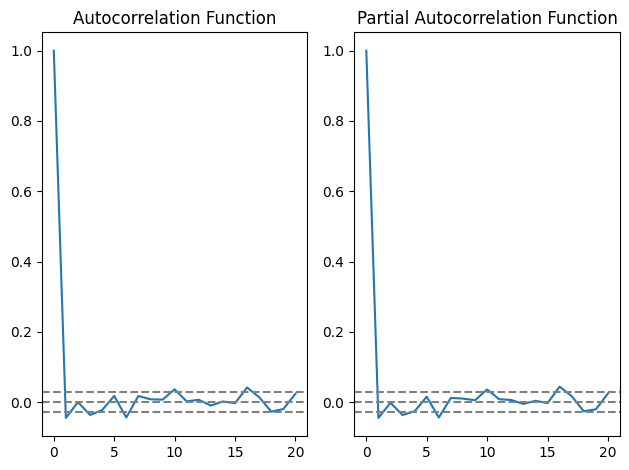

In [17]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

In [22]:
from plotly.subplots import make_subplots

# Supondo que datasetLogDiffShifting seja um pandas Series com seus dados de série temporal
lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

# Criar intervalo de confiança para ACF e PACF
conf_interval = 1.96/np.sqrt(len(datasetLogDiffShifting))

# Criar figura com subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('Autocorrelation Function', 'Partial Autocorrelation Function'))

# Adicionar ACF ao primeiro subplot
fig.add_trace(
    go.Scatter(
        x=np.arange(len(lag_acf)), 
        y=lag_acf, 
        mode='lines',
        name='ACF'
    ), 
    row=1, col=1
)

# Adicionar PACF ao segundo subplot
fig.add_trace(
    go.Scatter(
        x=np.arange(len(lag_pacf)), 
        y=lag_pacf, 
        mode='lines',
        name='PACF'
    ), 
    row=1, col=2
)

# Adicionar linhas de confiança para ACF e PACF
fig.add_trace(
    go.Scatter(
        x=np.arange(len(lag_acf)), 
        y=[conf_interval]*len(lag_acf), 
        mode='lines', 
        name='Upper Confidence Bound',
        line=dict(color='gray', dash='dash')
    ), 
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=np.arange(len(lag_acf)), 
        y=[-conf_interval]*len(lag_acf), 
        mode='lines', 
        name='Lower Confidence Bound',
        line=dict(color='gray', dash='dash')
    ), 
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=np.arange(len(lag_pacf)), 
        y=[conf_interval]*len(lag_pacf), 
        mode='lines', 
        line=dict(color='gray', dash='dash')
    ), 
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=np.arange(len(lag_pacf)), 
        y=[-conf_interval]*len(lag_pacf), 
        mode='lines', 
        line=dict(color='gray', dash='dash')
    ), 
    row=1, col=2
)

# Atualizar layout dos gráficos
fig.update_layout(
    title='ACF and PACF',
    showlegend=False
)

# Mostrar o gráfico
fig.show()
